<a href="https://colab.research.google.com/github/Theekshana-se/Air-QualityPredict-DeepLearningProject/blob/main/IT22165770_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load your cleaned dataset
df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Deep-Learning-Project-main/DataSet/airData.csv',
    encoding='ISO-8859-1'
)

# Select useful columns only
df = df[['sampling_date', 'state', 'location', 'so2', 'no2', 'rspm']]
df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')

# Drop rows missing key values
df = df.dropna(subset=['sampling_date', 'location', 'so2', 'no2', 'rspm'])

# Sort for time-series consistency
df = df.sort_values(['location', 'sampling_date'])
df.reset_index(drop=True, inplace=True)

/tmp/ipython-input-3467568969.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipython-input-3467568969.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')


In [10]:
le = LabelEncoder()
df['city_id'] = le.fit_transform(df['location'])
print(df[['location', 'city_id']].head(10))



     location  city_id
0  ANKLESHWAR        0
1  ANKLESHWAR        0
2  ANKLESHWAR        0
3  ANKLESHWAR        0
4  ANKLESHWAR        0
5  ANKLESHWAR        0
6  ANKLESHWAR        0
7  ANKLESHWAR        0
8  ANKLESHWAR        0
9  ANKLESHWAR        0


In [11]:
scaler = MinMaxScaler()
df[['so2', 'no2', 'rspm']] = scaler.fit_transform(df[['so2', 'no2', 'rspm']])


In [12]:
def create_sequences_for_all_cities(data, time_steps=10):
    X_all, y_all = [], []
    grouped = data.groupby('city_id')

    for city_id, group in grouped:
        group = group.sort_values('sampling_date')
        features = group[['so2', 'no2', 'rspm', 'city_id']].values
        for i in range(len(features) - time_steps):
            X_all.append(features[i:i+time_steps])
            y_all.append(features[i+time_steps, 2])  # target = RSPM
    return np.array(X_all), np.array(y_all)

X, y = create_sequences_for_all_cities(df, 10)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (362191, 10, 4)
Shape of y: (362191,)


In [13]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (289752, 10, 4)  Test: (72439, 10, 4)


In [14]:
model = Sequential()
model.add(GRU(128, input_shape=(10, 4), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 51,585 (201.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 105s 23ms/step - loss: 0.0563 - val_loss: 2.1257e-04
Epoch 2/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 102s 23ms/step - loss: 1.1633e-04 - val_loss: 5.2777e-05
Epoch 3/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - loss: 9.1670e-05 - val_loss: 4.6684e-05
Epoch 4/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - loss: 8.3805e-05 - val_loss: 5.9402e-05
Epoch 5/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - loss: 7.5086e-05 - val_loss: 3.7155e-05
Epoch 6/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - loss: 7.9581e-05 - val_loss: 8.7210e-05
Epoch 7/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 104s 23ms/step - loss: 7.3339e-05 - val_loss: 2.0286e-04
Epoch 8/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - loss: 7.0071e-05 - val_loss: 8.0349e-05
Epoch 9/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - loss: 6.5259e-05 - val_loss: 3.4932e-05
Epoch 10/10
4528/4528 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - loss: 6.4446e-05 - val_loss: 6.5443e-05


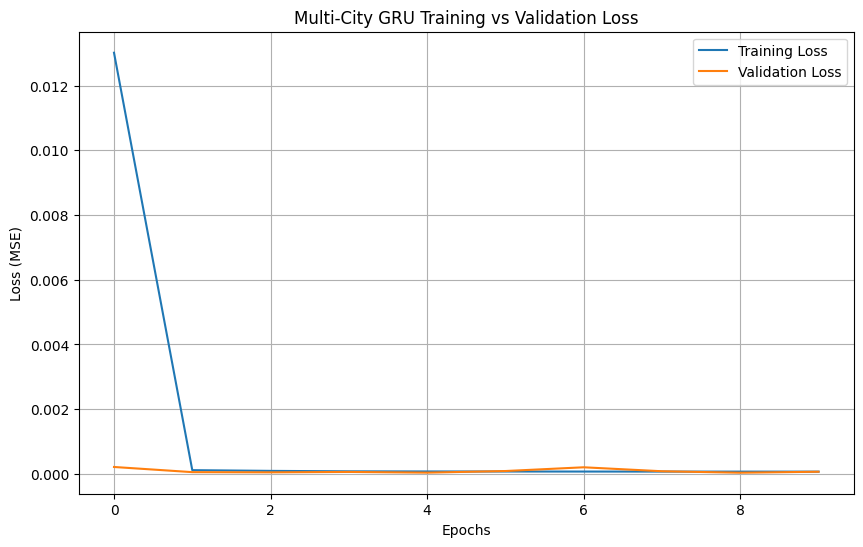

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Multi-City GRU Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² Score: {r2:.4f}")


2264/2264 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
RMSE: 0.0081
MAE : 0.0066
R² Score: -0.0231


In [18]:
city_id = le.transform(['Mumbai'])[0]
city_df = df[df['city_id'] == city_id].copy()
city_df = city_df.sort_values('sampling_date')

last_seq = city_df[['so2', 'no2', 'rspm', 'city_id']].values[-10:]
future_preds = []

for _ in range(7):  # predict next 7 days
    pred = model.predict(last_seq.reshape(1, 10, 4))
    future_preds.append(pred[0,0])
    new_row = np.array([[0, 0, pred[0,0], city_id]])  # placeholders for so2,no2
    last_seq = np.concatenate((last_seq[1:], new_row), axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [19]:
future_preds_real = scaler.inverse_transform(
    np.concatenate((np.zeros((len(future_preds), 2)), np.array(future_preds).reshape(-1,1)), axis=1)
)[:, 2]

print("Next 7 days RSPM predictions for Mumbai:")
print(future_preds_real)

Next 7 days RSPM predictions for Mumbai:
[120.3706903  113.64159398 109.22126243 108.48777897 103.93906784
 104.22147236 100.53813685]


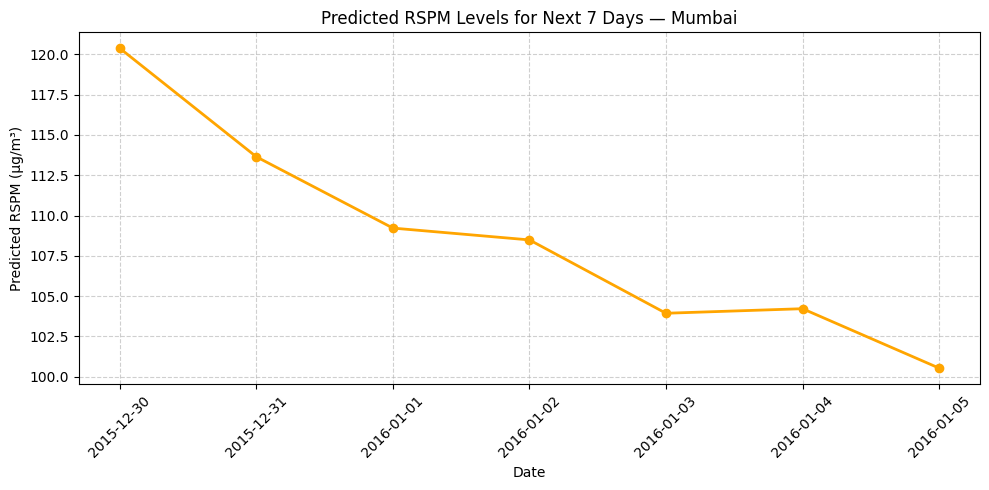

In [20]:
last_date = city_df['sampling_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(10,5))
plt.plot(future_dates, future_preds_real, marker='o', color='orange', linewidth=2)
plt.title(f'Predicted RSPM Levels for Next 7 Days — {le.inverse_transform([city_id])[0]}')
plt.xlabel('Date')
plt.ylabel('Predicted RSPM (µg/m³)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get all city IDs
city_ids = df['city_id'].unique()

all_city_forecasts = {}

for city_id in df['city_id'].unique():
    city_df = df[df['city_id'] == city_id].copy()
    city_df = city_df.sort_values('sampling_date')

    # Skip cities with too few records
    if len(city_df) < 10:
        print(f"Skipping city_id={city_id} ({le.inverse_transform([city_id])[0]}) - not enough data")
        continue

    last_seq = city_df[['so2', 'no2', 'rspm', 'city_id']].values[-10:]

    future_preds = []
    for _ in range(7):
        pred = model.predict(last_seq.reshape(1, 10, 4))
        future_preds.append(pred[0, 0])

        new_row = np.array([[0, 0, pred[0, 0], city_id]])
        last_seq = np.concatenate((last_seq[1:], new_row), axis=0)

    # inverse transform RSPM only
    future_preds_real = scaler.inverse_transform(
        np.concatenate((np.zeros((len(future_preds), 2)), np.array(future_preds).reshape(-1,1)), axis=1)
    )[:, 2]

    city_name = le.inverse_transform([city_id])[0]
    all_city_forecasts[city_name] = future_preds_real


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━

/tmp/ipython-input-878018679.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


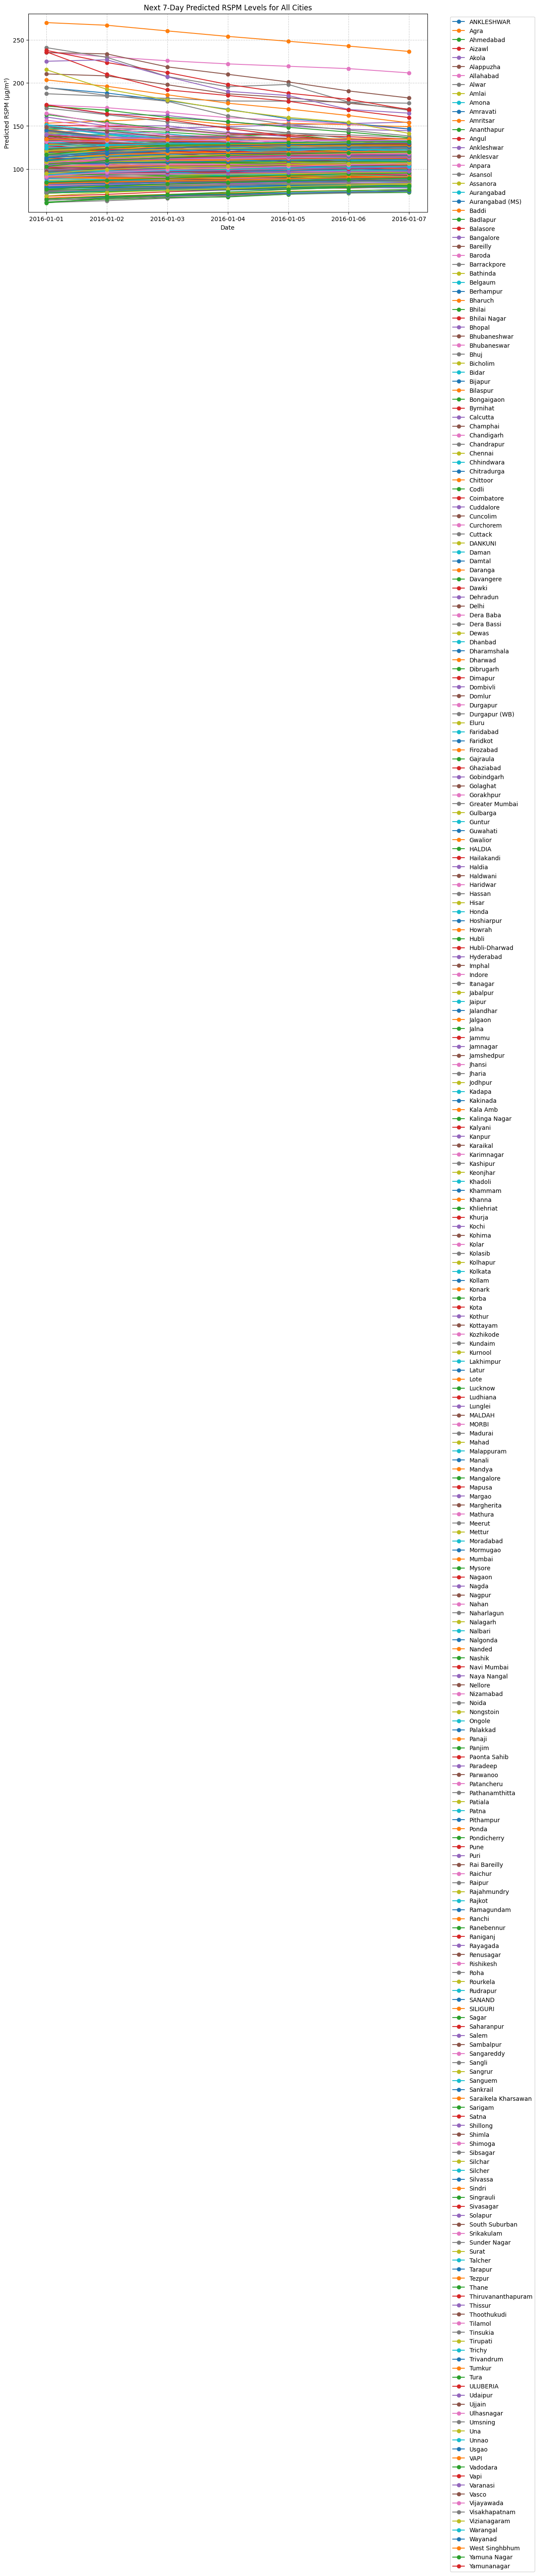

In [23]:
plt.figure(figsize=(12,6))
future_dates = pd.date_range(df['sampling_date'].max() + pd.Timedelta(days=1), periods=7)

for city_name, preds in all_city_forecasts.items():
    plt.plot(future_dates, preds, marker='o', label=city_name)

plt.title('Next 7-Day Predicted RSPM Levels for All Cities')
plt.xlabel('Date')
plt.ylabel('Predicted RSPM (µg/m³)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [24]:
n = len(all_city_forecasts)
fig, axes = plt.subplots(nrows=(n//3)+1, ncols=3, figsize=(15, 4*(n//3)+2))
axes = axes.flatten()

for i, (city_name, preds) in enumerate(all_city_forecasts.items()):
    axes[i].plot(future_dates, preds, marker='o', color='orange')
    axes[i].set_title(f'{city_name} (Next 7 Days)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('RSPM (µg/m³)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()
